In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from sklearn.discriminant_analysis import \
(LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns

from collections import Counter

import random
import time
import requests
from bs4 import BeautifulSoup, Comment
from io import StringIO

# **Predicting NFL Playoff Teams Based on Previous Season Stats**

## 1. Introduction

This mini project began as a self-driven exercise as I was reading chapter 4 of "An Introduction to Statistical Learning" by James, Witten, Hastie, Tibshirani, and Taylor. The goal is to determine which rudimentary or team-level statistics (if any) from the previous NFL season can be used to predict whether or not a team will make the playoffs in the next season. This will broadly measure how success or failure in one season carries over to the next.

## 2. Data Sources and Arrangement

All data was obtained from Pro Football Reference (https://www.pro-football-reference.com/) for the regular seasons between 1990-2024. The data was collected in two stages and via two methods.

First, in my stubbornness and refusal to use web scraping, I manually copied and pasted the yearly team standings (see the AFC and NFC tables at https://www.pro-football-reference.com/years/2024/, for example) into a spreadsheet. I then manually changed the team names to reflect the current franchise abbreviations (e.g. 'Houston Oilers' and 'Tennessee Oilers' $\mapsto$ 'TEN' for the Tennessee Titans). To cap off this unnecessarily tedious endeavor, I added a column 'Playoffs' in which a 1 indicates a team made the playoffs that season and a 0 indicates they did not.

In [2]:
season_stats = pd.read_csv("/Users/coledurham/Documents/nfl_playoff_predictor/data/Seasonal Stats - Season Stats.csv")
season_stats = season_stats.replace('AZ', 'ARI') #Accidentally used AZ instead of ARI in some place(s); changed to ARI
season_stats.head()

,Tm,Season,W,L,T,win_percent,PF,PA,PD,MoV,SoS,SRS,OSRS,DSRS,Playoffs
0,BUF,2024,13,4,0,0.765,525,368,157,9.2,-1.1,8.1,7.8,0.3,1
1,MIA,2024,8,9,0,0.471,345,364,-19,-1.1,-1.9,-3.0,-3.5,0.4,0
2,NYJ,2024,5,12,0,0.294,338,404,-66,-3.9,-0.5,-4.3,-3.0,-1.4,0
3,NE,2024,4,13,0,0.235,289,417,-128,-7.5,-0.6,-8.1,-6.2,-1.9,0
4,BAL,2024,12,5,0,0.706,518,361,157,9.2,0.6,9.9,8.0,1.9,1


In the dataframe season_stats, each row contains:


*   Tm: Team abbreviation
*   Season: Year of season
*   W, L, T: Wins, losses, and ties
*   win_percent: Win percentage
*   $PF$: Points for
*   $PA$: Points against
*   $PD$: Point differential, given by PF-PA
*   $MoV$: Average margin of victory, given by $\frac{PF-PA}{W+L+T}$
*   $SoS$: Strength of schedule
*   SRS: Simple rating system, given by $MoV+SoS$
*   OSRS/DSRS: Offensive and defensive ratings from the simple rating system
*   Playoffs: Binary variable indicating whether a team made the playoffs (1) or missed the playoffs (0)

win percentage, points for, points against, point differential (PF-PA), average margin ((PF-PA)/W+L+T), strength of schedule, simple rating (MoV+SoS), offensive simple rating, and defensive simple rating.

Next, to gain more information about each team and the constitution of their roster, I used the requests.get( ) method to scrape the roster page for each team in each season (see https://www.pro-football-reference.com/teams/buf/2024_roster.htm, for example). Of note in the scraping logic: 'BeautifulSoup' is used in conjunction with 'pandas.read_html' to extract the appropriate table from the page HTML; the team abbreviations used by PFR are converted to my preferred abbreviations using a dictionary.

In [ ]:
team_abbrevs_pfr = ['buf', 'nyj', 'mia', 'nwe', 'kan', 'sdg', 'den', 'rai', 'pit', 'rav', 'cin', 'cle', 'htx', 'jax',
                    'oti', 'clt', 'phi', 'nyg', 'was', 'dal', 'ram', 'sfo', 'sea', 'crd', 'gnb', 'det', 'min', 'chi', 'tam', 'nor', 'car', 'atl']


all_rosters = []
for team in team_abbrevs_pfr:
    print(f"Starting team: {team.upper()}")
    for year in range(1990, 2025):

        time.sleep(random.uniform(1,2))

        url = f"https://www.pro-football-reference.com/teams/{team}/{year}_roster.htm"
        print(f"  Processing year {year}...")

        try:
            res = requests.get(url)
            res.raise_for_status()
            soup = BeautifulSoup(res.content, 'html.parser')
            comments = soup.find_all(string=lambda text: isinstance(text, Comment))

            for comment in comments:
                if 'id="roster"' in comment:
                    comment_soup = BeautifulSoup(comment, 'html.parser')
                    table = comment_soup.find('table', {'id': 'roster'})
                    if table:
                        df = pd.read_html(StringIO(str(table)))[0]

                        df['Year'] = year
                        df['Tm_raw'] = team
                        df['Tm'] = df['Tm_raw'].map(pfr_to_standard_tm)

                        all_rosters.append(df)
                        break

            time.sleep(random.uniform(6,10))

        except Exception as e:
            print(f"    Failed for {year}: {e}")

df = pd.concat(all_rosters, ignore_index=True)

This produces a dataframe df which, after a small amount of cleaning, renaming, and saving as a csv for convenience, looks like the following.

In [4]:
nfl_rosters = pd.read_csv('/Users/coledurham/Documents/nfl_playoff_predictor/data/NFL_rosters.csv')
NFL_rosters = nfl_rosters[['Player', 'Year', 'Tm', 'Age', 'Pos', 'G', 'GS', 'Ht', 'Wt', 'College/Univ', 'BirthDate', 'Yrs', 'AV', 'Drafted (tm/rnd/yr)' ]]
# Replacing 'Rook' with 0 in the 'Yrs' column
NFL_rosters.loc[NFL_rosters["Yrs"] == "Rook", "Yrs"] = '0'
NFL_rosters
NFL_rosters.head()

/var/folders/r5/2kqnsbq5415711cgxzzqhd4r0000gn/T/ipykernel_74643/1877230849.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  NFL_rosters.loc[NFL_rosters["Yrs"] == "Rook", "Yrs"] = '0'


,Player,Year,Tm,Age,Pos,G,GS,Ht,Wt,College/Univ,BirthDate,Yrs,AV,Drafted (tm/rnd/yr)
0,Jim Bakken,1970,ARI,30.0,K,14,0.0,5-11,200.0,Wisconsin,11/2/1940,8.0,5.0,Los Angeles Rams / 7th / 88th pick / 1962
1,Pete Beathard,1970,ARI,28.0,QB,4,0.0,6-1,200.0,USC,3/7/1942,6.0,1.0,"Kansas City Chiefs / 1st / 2nd pick / 1964, De..."
2,Robert Brown,1970,ARI,27.0,TE,14,1.0,6-2,225.0,Alcorn St.,1/1/1943,1.0,0.0,NaN
3,Terry Brown,1970,ARI,23.0,DB,10,1.0,6-0,205.0,Oklahoma St.,1/9/1947,1.0,1.0,St. Louis Cardinals / 3rd / 73rd pick / 1969
4,Jerry Daanen,1970,ARI,26.0,WR,14,0.0,6-0,190.0,Miami (FL),12/15/1944,2.0,0.0,St. Louis Cardinals / 8th / 205th pick / 1968


In each row we see:
* No.: Jersey number
* Player: Name of player
* Year: Calendar year corresponding to the season
* Tm: Team, as previously
* Age: How old the player is in years
* Pos: Player position
* G: Games played
* GS: Games started
* Ht: Height, formatted as feet-inches
* Wt: Weight in pounds
* College/Univ: College(s) attended by the player
* BirthDate: Date on which player was born
* Yrs: Years the player has been in professional football
* AV: Average value, a metric produced by PFR for every player since 1960
* Drafted: Information regarding when the player was selected within the NFL draft

With regards to making or missing the playoffs next year, it is reasonable to expect the average age of the roster and the number of rookies this year to have an impact. Of course, there is a glaring issue with our information so far: roster turnover rates are unaccounted for! From one year to the next an NFL roster can be completely transformed, but for the simplicity of the present model we ignore this.

For an overview of team composition among relevant players, we find the average age and experience of roster members who played in at least 8 games (approximately half the season irrespective of year), as well as the total number of rookies on the roster.

In [5]:
NFL_rosters.loc[:, 'Yrs'] = pd.to_numeric(NFL_rosters['Yrs'], errors='coerce')
NFL_rosters.loc[:, 'Age'] = pd.to_numeric(NFL_rosters['Age'], errors='coerce')

avg_exp_age_data = []

for year in range(1990, 2025):
    rosters_in_year = NFL_rosters[NFL_rosters['Year'] == year]
    for team in rosters_in_year['Tm'].unique():
        team_roster = rosters_in_year[rosters_in_year['Tm'] == team]
        rel_roster = team_roster[team_roster['G'] >= 8] # Note G restriction
        avg_exp = rel_roster['Yrs'].mean()
        avg_age = rel_roster['Age'].mean()
        num_rookies = len(team_roster[team_roster['Yrs'] == 0]) #Adding in ALL rookies. Future contributors.
        avg_exp_age_data.append({
            'Year': year,
            'Tm': team,
            'Avg Age': avg_age,
            'Avg Experience': avg_exp,
            'Num Rookies': num_rookies
        })

# Convert to DataFrame
avg_exp_age_df = pd.DataFrame(avg_exp_age_data)
avg_exp_age_df.head()

,Year,Tm,Avg Age,Avg Experience,Num Rookies
0,1990,ARI,26.652174,3.717391,10
1,1990,ATL,26.227273,3.386364,8
2,1990,BUF,26.777778,3.511111,10
3,1990,CHI,26.782609,3.826087,12
4,1990,CIN,26.456522,3.565217,8


In each row of 'avg_exp_age_df' we see:
* Year: Calendar year corresponding to the season
* Tm: Team, as previously
* Avg Age: Average age among players who played in at least 8 games
* Avg Experience: Average number of years in the NFL among players who played in at least 5 games
* Num Rookies: Total number of rookies on the roster

Next, we merge 'season_stats' and 'avg_exp_age_df' on the columns 'Tm', 'Season' and 'Tm', 'Year'; we then add a column 'playoffs_next_yr' by a group shift. This introduces 'NaN' entries in the year 2024, as the 2025 NFL season has yet to be played. These rows are dropped, and what remains is the data we will work with.

In [6]:
stats = pd.merge(left=season_stats,
                 right=avg_exp_age_df,
                 how='left',
                 left_on=['Tm', 'Season'],
                 right_on=['Tm', 'Year'])

stats = stats.drop('Season', axis=1)
stats = stats[['Year', 'Tm', 'W', 'L', 'win_percent', 'PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS', 'OSRS', 'DSRS', 'Avg Age', 'Avg Experience', 'Num Rookies', 'Playoffs']]


stats_sorted = stats.sort_values(by = ['Tm', 'Year']) #GROUP TEAM DATA TOGETHER
stats_sorted['playoffs_next_yr'] = stats_sorted.groupby('Tm')['Playoffs'].shift(-1)


Data = stats_sorted[['win_percent', 'PF', 'PA', 'PD', 'SoS', 'SRS', 'OSRS', 'DSRS','Avg Experience', 'Avg Age', 'Num Rookies','Playoffs', 'playoffs_next_yr']].dropna()
Data.head()

,win_percent,PF,PA,PD,SoS,SRS,OSRS,DSRS,Avg Experience,Avg Age,Num Rookies,Playoffs,playoffs_next_yr
1079,0.313,268,396,-128,1.3,-6.7,-1.9,-4.8,3.717391,26.652174,10,0,0.0
1051,0.250,196,344,-148,3.8,-5.4,-4.9,-0.5,3.000000,25.977778,11,0,0.0
1023,0.250,243,332,-89,2.5,-3.1,-2.9,-0.1,3.681818,26.522727,9,0,0.0
994,0.438,326,269,57,0.4,3.9,1.9,2.1,4.785714,27.547619,9,0,0.0
965,0.500,235,267,-32,-0.3,-2.3,-5.6,3.3,3.869565,26.521739,14,0,0.0


Note that we drop the columns 'W', 'L', and 'T' in favor of just 'win_percent' since it contains the same information. We also drop 'Year' because while the percentage of teams to make the playoff has fluctuated over time due to changes in format and total number of teams, it has only ever ranged between 37.5% (2002-2019) and 43.8% (2020-2024).

## 3. Descriptive Statistics

To get a sense of how our features relate to one another and to the label 'playoffs_next_yr,' we first look at the correlation matrix for the data.

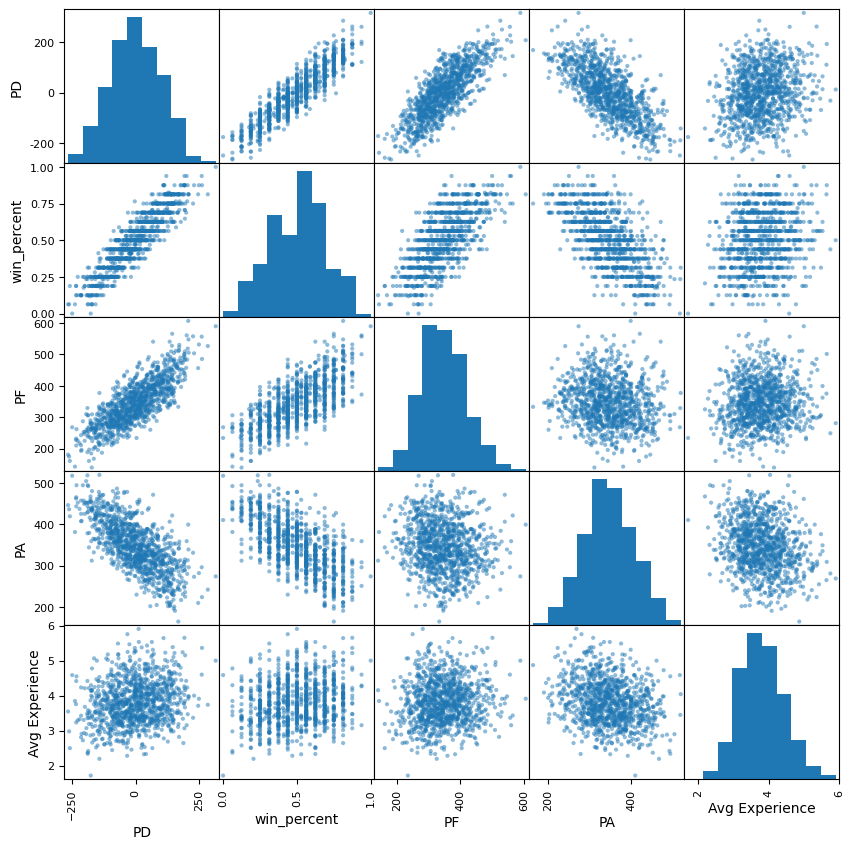

In [ ]:
pd.plotting.scatter_matrix(Data[['PD', 'win_percent', 'PF', 'PA', 'Avg Experience']], figsize=(10,10));

In [ ]:
Data[Data.columns.drop('playoffs_next_yr').to_list()].corr()

,win_percent,PF,PA,PD,SoS,SRS,OSRS,DSRS,Avg Experience,Avg Age,Num Rookies,Playoffs
win_percent,1.000000,0.717406,-0.652709,0.910952,-0.231388,0.877805,0.732139,0.647015,0.181465,0.154343,-0.321213,0.780707
PF,0.717406,1.000000,-0.133908,0.799810,-0.205059,0.769534,0.923178,0.222584,0.088090,0.047272,-0.194280,0.557122
PA,-0.652709,-0.133908,1.000000,-0.701949,0.143670,-0.685234,-0.258685,-0.887871,-0.238931,-0.243984,0.319154,-0.509301
PD,0.910952,0.799810,-0.701949,1.000000,-0.234398,0.968116,0.820177,0.697762,0.208033,0.181757,-0.332943,0.708892
SoS,-0.231388,-0.205059,0.143670,-0.234398,1.000000,0.015971,-0.038136,0.074883,-0.015907,-0.016416,0.039844,-0.210244
SRS,0.877805,0.769534,-0.685234,0.968116,0.015971,1.000000,0.833602,0.737359,0.209682,0.182619,-0.332351,0.675124
OSRS,0.732139,0.923178,-0.258685,0.820177,-0.038136,0.833602,1.000000,0.241634,0.174605,0.156998,-0.279162,0.564029
DSRS,0.647015,0.222584,-0.887871,0.697762,0.074883,0.737359,0.241634,1.000000,0.155240,0.129380,-0.242655,0.496217
Avg Experience,0.181465,0.088090,-0.238931,0.208033,-0.015907,0.209682,0.174605,0.155240,1.000000,0.953852,-0.527433,0.105981
Avg Age,0.154343,0.047272,-0.243984,0.181757,-0.016416,0.182619,0.156998,0.129380,0.953852,1.000000,-0.501493,0.086277


Some correlation coefficients in the above table/matrix are expected, but of note. First, win percentage and point differential have a strong, positive correlation. Unsurprisingly, PD has reasonably strong correlation with PF and PA, though it is interesting that it has a slightly more positive correlation with PF than negative correlation with PA. These connections will be further explored when determining features to keep in the model(s).

Next, we make several plots which show if any features are split into distinct regimes by the label 'playoffs_next_yr'. For instance, if a team has a strong win percentage this year, how likely is that success to be retained?

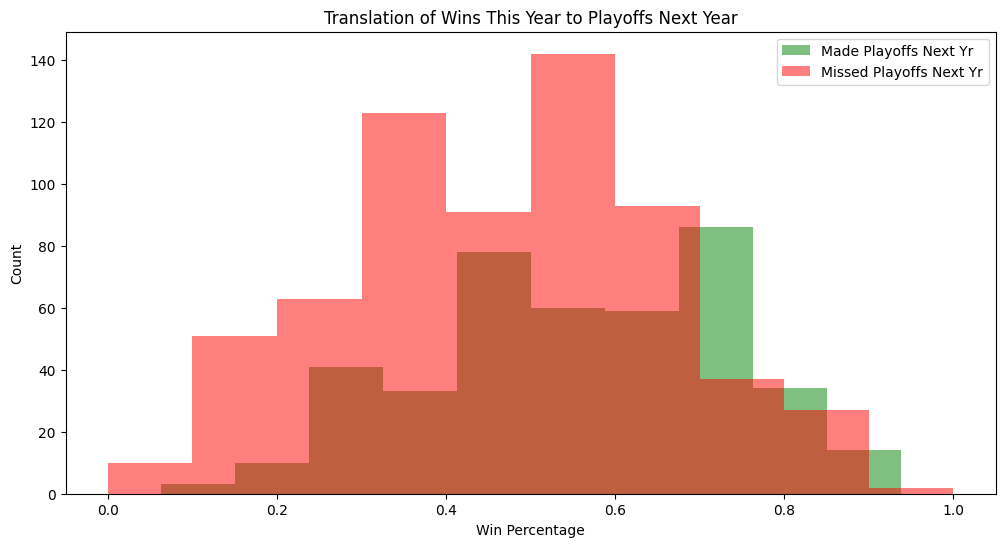

In [ ]:
stats_playoffs_next_yes = Data[Data['playoffs_next_yr'] == 1]
stats_playoffs_next_no = Data[Data['playoffs_next_yr'] == 0]

plt.figure(figsize=(12,6))
plt.hist(stats_playoffs_next_yes['win_percent'], color='green', label="Made Playoffs Next Yr", alpha=0.5)
plt.hist(stats_playoffs_next_no['win_percent'], color='red', label="Missed Playoffs Next Yr" ,alpha=0.5)
plt.xlabel("Win Percentage")
plt.ylabel("Count")
plt.legend()
plt.title("Translation of Wins This Year to Playoffs Next Year");

Among all teams who made the playoffs in the upcoming season, their average win percentage this season is 56.1%; among their counterparts who did not make the playoffs in the upcoming season, the average win percentage was 46.1%. However, as the histogram above makes evident, there is substantial overlap between the two distributions. This gives some doubt as to the potential of win percentage as a feature.

Another similar plot: does a high (resp. low) point differential this year have a lingering impact next year? Despite the correlation between PD and win percentage, it is possible that PD has a stronger carryover between seasons.

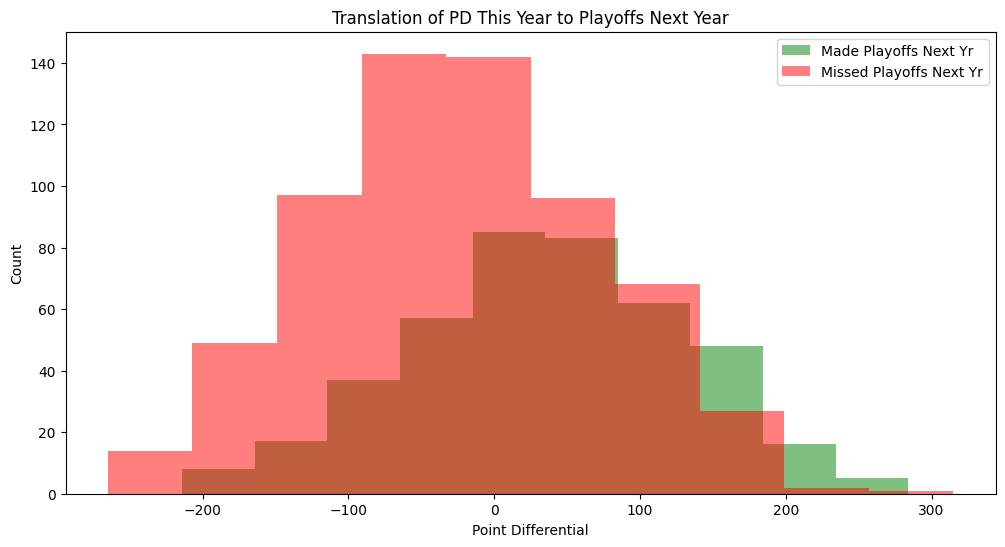

In [ ]:
plt.figure(figsize=(12,6))
plt.hist(stats_playoffs_next_yes['PD'], color='green', label="Made Playoffs Next Yr", alpha=0.5)
plt.hist(stats_playoffs_next_no['PD'], color='red', label="Missed Playoffs Next Yr" ,alpha=0.5)
plt.xlabel("Point Differential")
plt.ylabel("Count")
plt.legend()
plt.title("Translation of PD This Year to Playoffs Next Year");

The average PD this year among playoff teams next year is 36.6, while the average PD this year among non-playoff teams next year is -23.8. The distributions are still heavily overlapped.

Lastly, how does the SRS metric perform in the same light?

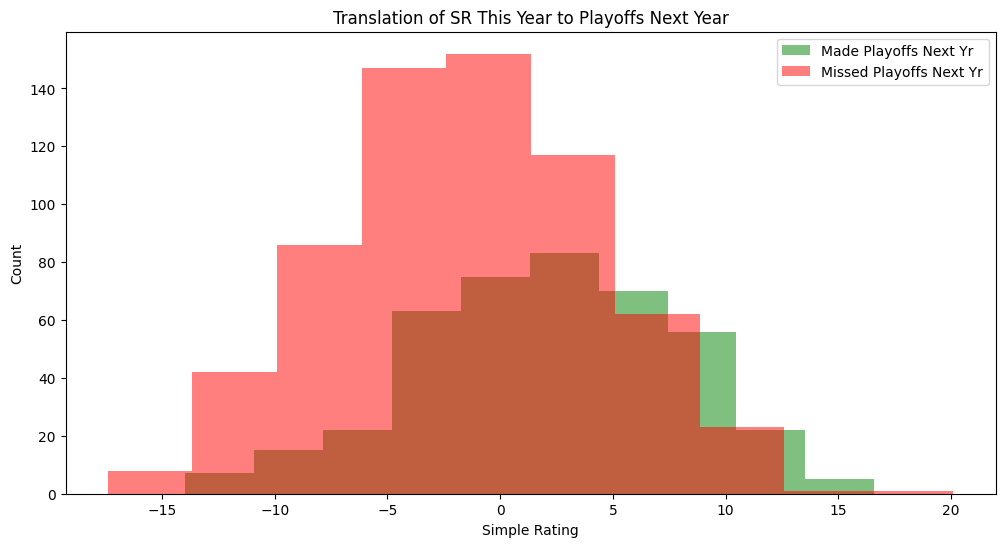

In [ ]:
plt.figure(figsize=(12,6))
plt.hist(stats_playoffs_next_yes['SRS'], color='green', label="Made Playoffs Next Yr", alpha=0.5)
plt.hist(stats_playoffs_next_no['SRS'], color='red', label="Missed Playoffs Next Yr" ,alpha=0.5)
plt.xlabel("Simple Rating")
plt.ylabel("Count")
plt.legend()
plt.title("Translation of SR This Year to Playoffs Next Year");

As expected by now, this single feature does not entirely split the data. We can try two-dimensional plots as well, as they too help to see the lines between the two classes.

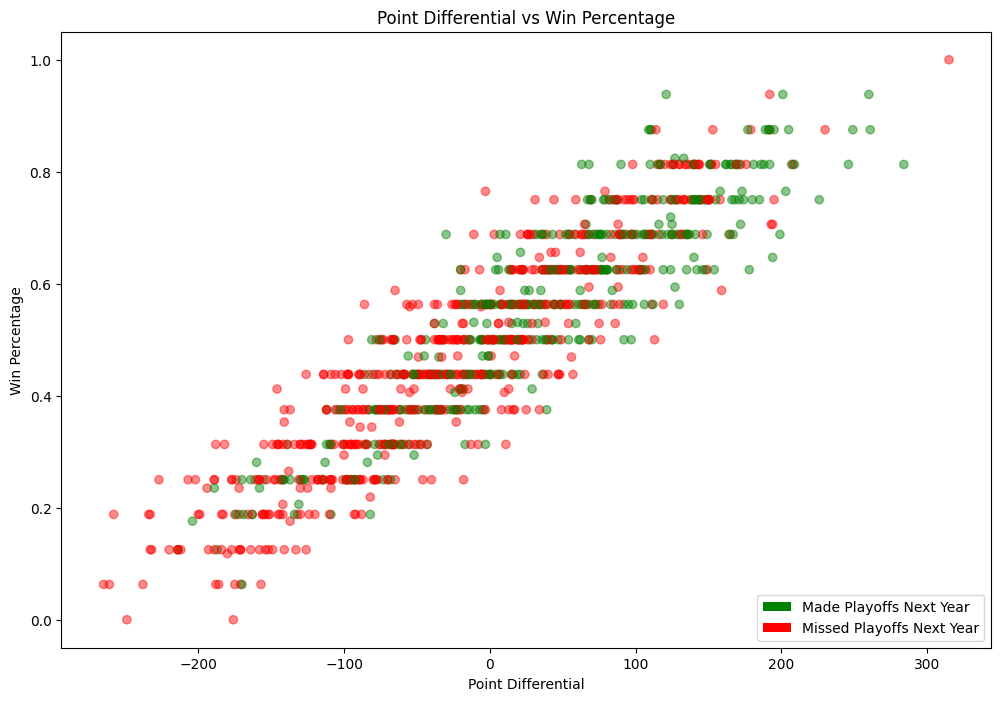

In [ ]:
from matplotlib.patches import Patch

colors = Data['playoffs_next_yr'].map({0: 'red', 1: 'green'})

legend_elements = [Patch(facecolor='green', label='Made Playoffs Next Year'),
                   Patch(facecolor='red', label='Missed Playoffs Next Year')]

plt.figure(figsize=(12,8))
plt.scatter(Data['PD'], Data['win_percent'], c=colors, alpha=0.45)
plt.xlabel("Point Differential")
plt.ylabel("Win Percentage")
plt.title("Point Differential vs Win Percentage")
plt.legend(handles=legend_elements, loc="lower right")
plt.show()

This plot gives further support to the claim that point differential and/or win percentage may be useful in classifying playoff teams since the density of red points is visually higher close to the origin.

A final generic piece of information to keep in mind: there are more teams that miss the playoffs every year than teams that make the playoffs. Indeed, 39.6% (418/1056) of the data points in our set are teams who made the playoffs in the next season while 60.4% (638/1056) did not.

## 4. Logistic Regression Model

In this section we train and test a logistic regression model using the 'statsmodels' module, but to start we will eliminate certain features which cause significant multicollinearity. Specifically, we use the variance inflation factor (VIF) to determine a subset of features.

In [7]:
features = Data.columns.drop(['playoffs_next_yr'])
X = Data[features]
y = Data['playoffs_next_yr']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)
X_train_sm = sm.add_constant(X_train)

In [8]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
print(vif_data)


           feature           VIF
0      win_percent  6.224478e+01
1               PF           inf
2               PA           inf
3               PD           inf
4              SoS  2.082820e+02
5              SRS  1.488727e+04
6             OSRS  6.673403e+03
7             DSRS  4.548629e+03
8   Avg Experience  9.130843e+01
9          Avg Age  4.611932e+02
10     Num Rookies  1.482436e+01
11        Playoffs  4.357755e+00


/Users/coledurham/Documents/nfl_playoff_predictor/env39/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


From this table, we see that many of our features can be eliminated. Indeed as previously observed, PF and PA completely determine PD. We retain 'Playoffs', 'Num Rookies', 'Avg Experience', 'SoS', 'Playoffs', and 'PD'. (Note PD is retained since it is correlated with win percentage and demonstrates higher predictive significance.)

In [9]:
features = ['Playoffs', 'Avg Experience', 'Num Rookies','SoS', 'PD']
X = Data[features]
y = Data['playoffs_next_yr']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)
X_train_sm = sm.add_constant(X_train)

class_counts = Counter(y_train)
n_total = len(y_train)

sample_weights = y_train.map({
    0: n_total / (2 * class_counts[0]),
    1: n_total / (2 * class_counts[1])
})

model = sm.GLM(
    y_train,
    X_train_sm,
    family=sm.families.Binomial(),
    freq_weights=sample_weights
)

results = model.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       playoffs_next_yr   No. Observations:                  845
Model:                            GLM   Df Residuals:                   839.00
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -541.10
Date:                Tue, 08 Jul 2025   Deviance:                       1082.2
Time:                        21:30:28   Pearson chi2:                     841.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1002
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.1688      0.718      1.

This shows that among the features presented, only point differential is strongly significant. Average experience is marginally significant with a $p$-value of 0.041, while strength of schedule is next best with a $p$-statistic of 0.132. We will test models on feature sets $\{\text{ PD}\}$, $\{\text{PD, Avg Experience}\}$, and $\{\text{PD, Avg Experience, SoS}\}$. This choice is further supported by standard feature selection methods, Recursive Feature Elimination (RFE) and Lasso ($L^1$-regularized logistic regression).

In [10]:
from sklearn.feature_selection import RFE
X = Data[['Playoffs', 'PD', 'Num Rookies', 'Avg Experience', 'SoS']]
y = Data['playoffs_next_yr']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

lr = LogisticRegression(solver='liblinear')

rfe = RFE(estimator=lr, n_features_to_select=3)
rfe.fit(X_train_scaled, y_train)

selected_features = X.columns[rfe.support_]
print("Selected features via RFE:", list(selected_features))

Selected features via RFE: ['PD', 'Avg Experience', 'SoS']


In [11]:
from sklearn.linear_model import LogisticRegressionCV
lasso = LogisticRegressionCV(
    Cs=10,
    penalty='l1',
    solver='liblinear',
    cv=5,
    scoring='accuracy',
    random_state=42
)

lasso.fit(X_train_scaled, y_train)

# Coefficients
coefficients = pd.Series(lasso.coef_[0], index=X.columns)
print("L1-selected coefficients:\n", coefficients);

L1-selected coefficients:
 Playoffs         -0.024737
PD                0.754681
Num Rookies      -0.042028
Avg Experience   -0.206371
SoS               0.103849
dtype: float64


In [12]:
features_1 = ['PD']
X1 = Data[features_1]
y = Data['playoffs_next_yr']

X1_train, X1_test, y_train, y_test = train_test_split(X1,y, test_size=0.2, stratify=y, random_state=42)
X1_train_sm = sm.add_constant(X1_train)
model = sm.GLM(
    y_train,
    X1_train_sm,
    family=sm.families.Binomial(),
    freq_weights=sample_weights
)

results_1 = model.fit()
print(results_1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       playoffs_next_yr   No. Observations:                  845
Model:                            GLM   Df Residuals:                   843.00
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -544.67
Date:                Tue, 08 Jul 2025   Deviance:                       1089.3
Time:                        21:31:11   Pearson chi2:                     844.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.09257
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0490      0.073     -0.676      0.4

This single-variable model shows that PD is a significant feature on its own.

In [13]:
features_2 = ['PD', 'Avg Experience']
X2 = Data[features_2]
y = Data['playoffs_next_yr']

X2_train, X2_test, y_train, y_test = train_test_split(X2,y, test_size=0.2, stratify=y, random_state=42)
X2_train_sm = sm.add_constant(X2_train)
model = sm.GLM(
    y_train,
    X2_train_sm,
    family=sm.families.Binomial(),
    freq_weights=sample_weights
)

results_2 = model.fit()
print(results_2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       playoffs_next_yr   No. Observations:                  845
Model:                            GLM   Df Residuals:                   842.00
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -542.43
Date:                Tue, 08 Jul 2025   Deviance:                       1084.9
Time:                        21:31:38   Pearson chi2:                     841.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.09736
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.9121      0.462      1.

Interestingly, when Avg Experience is paired with just PD it becomes slightly more significant. According to the pseudo-$R^2$ and log-likelihood values, the model is somewhat improved.

In [14]:
features_3 = ['PD', 'Avg Experience', 'SoS']
X3 = Data[features_3]
y = Data['playoffs_next_yr']

X3_train, X3_test, y_train, y_test = train_test_split(X3,y, test_size=0.2, stratify=y, random_state=42)
X3_train_sm = sm.add_constant(X3_train)
model = sm.GLM(
    y_train,
    X3_train_sm,
    family=sm.families.Binomial(),
    freq_weights=sample_weights
)

results_3 = model.fit()
print(results_3.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       playoffs_next_yr   No. Observations:                  845
Model:                            GLM   Df Residuals:                   841.00
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -541.23
Date:                Tue, 08 Jul 2025   Deviance:                       1082.5
Time:                        21:31:53   Pearson chi2:                     841.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.09993
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.9301      0.463      2.

Adding in SoS also improves the model fit slightly, but SoS itself remains insignificant. Given this, we omit SoS as a feature for the sake of model interpretability. For the time being, our feature set is $\{\text{PD, Avg Experience}\}$. We next test the model performance first with the classic threshold of $p=0.5$: if based on PD and Avg Experience the predicted probability of making the playoffs is at least 0.5, the team is predicted to make the playoffs next year.

In [15]:
X2_test_sm = sm.add_constant(X2_test)

y2_prob = results_2.predict(X2_test_sm)
y_pred = (y2_prob >= 0.5).astype(int)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

[[86 42]
 [34 50]]
              precision    recall  f1-score   support

         0.0      0.717     0.672     0.694       128
         1.0      0.543     0.595     0.568        84

    accuracy                          0.642       212
   macro avg      0.630     0.634     0.631       212
weighted avg      0.648     0.642     0.644       212



This initial test reveals several things, but perhaps the biggest is that the overall accuracy of the model (64.2%) outperforms the uninformed prediction that every team will miss the playoffs (60.4%). The model also only manages 60% recall and 54% precision in the class of teams we are likely more interested in (class 1, playoff teams), which is underwhelming. We can attempt to tune the classification threshold in order to improve model performance.

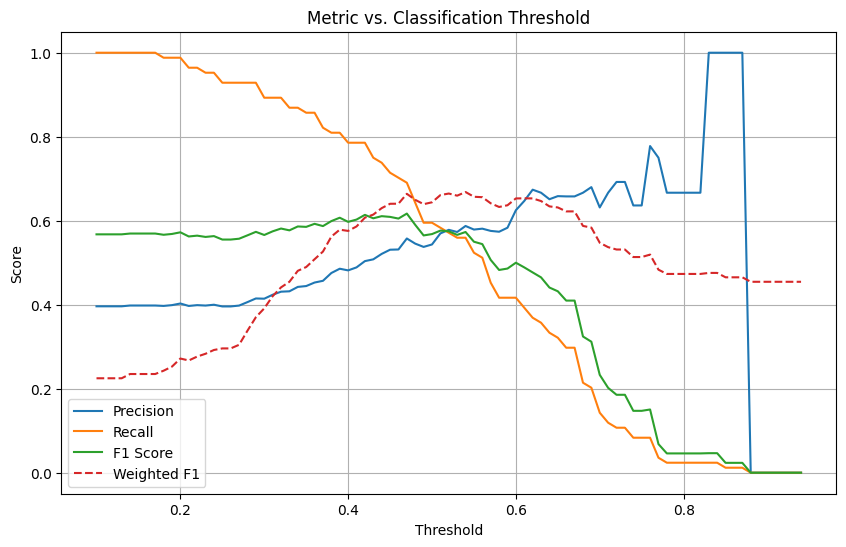

In [16]:
precisions = []
recalls = []
f1s = []
weighted_f1s = []
thresholds = np.arange(0.1, 0.95, 0.01)

for p in thresholds:
    y_pred = (y2_prob >= p).astype(int)
    precisions.append(precision_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred, zero_division=0))
    f1s.append(f1_score(y_test, y_pred, zero_division=0))
    weighted_f1s.append(f1_score(y_test, y_pred, average='weighted', zero_division=0))


# Plotting all metrics
plt.figure(figsize=(10,6));
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.plot(thresholds, weighted_f1s, label='Weighted F1', linestyle='--')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Metric vs. Classification Threshold")
plt.legend()
plt.grid(True)
plt.show();

From the above plot we can see that the F1 score peaks at a threshold below 0.5 while the weighted F1 score (weighted average of the F1 score of each class according to frequency) peaks at a threshold above 0.5. This is related to the fact that the unweighted F1 score only takes into account the precision and recall when predicting playoff teams.

In [17]:
best_idx = np.argmax(f1s)
print(f"Best F1 Score: {f1s[best_idx]:.3f} at threshold {thresholds[best_idx]:.2f}")

Best F1 Score: 0.617 at threshold 0.47


In [18]:
best_idx_weighted = np.argmax(weighted_f1s) #Find max entry of f1s array and what the threshold is there...but precision is quite low there!
print(f"Best Weighted F1 Score: {weighted_f1s[best_idx_weighted]:.3f} at threshold {thresholds[best_idx_weighted]:.2f}")

Best Weighted F1 Score: 0.668 at threshold 0.54


These are different thresholds for a reason. The first is more aggressive in predicting a team will make the playoffs: in order to maximize F1, need to increase recall of playoff teams to a certain extent. The second is relatively conservative in predicting a team will make the playoffs: there is significant value in the weighted formula placed on correctly predicting non-playoff teams!

Something important to keep in mind: which threshold we ultimately use may depend on context. As an NFL scout we might want to use the more aggressive model to be wary of more opponents; as a fan placing a bet on which team will make the playoffs, we want to be conservative (though assuming little risk usually doesn't pay much).

We can evaluate our model performance with these two new thresholds.

In [19]:
y2_pred_f1 = (y2_prob >= thresholds[best_idx]).astype(int)

print(confusion_matrix(y_test, y2_pred_f1))
print(classification_report(y_test, y2_pred_f1, digits=3))

[[82 46]
 [26 58]]
              precision    recall  f1-score   support

         0.0      0.759     0.641     0.695       128
         1.0      0.558     0.690     0.617        84

    accuracy                          0.660       212
   macro avg      0.658     0.666     0.656       212
weighted avg      0.679     0.660     0.664       212



In [20]:
y_pred_f1w = (y2_prob >= thresholds[best_idx_weighted]).astype(int)

print(confusion_matrix(y_test, y_pred_f1w))
print(classification_report(y_test, y_pred_f1w, digits=3))

[[95 33]
 [37 47]]
              precision    recall  f1-score   support

         0.0      0.720     0.742     0.731       128
         1.0      0.588     0.560     0.573        84

    accuracy                          0.670       212
   macro avg      0.654     0.651     0.652       212
weighted avg      0.667     0.670     0.668       212



We see it fully fleshed out now that the models accomplish different goals. The first has a 69% recall among playoff teams. The second only catches 57% of playoff teams, but when it does predict that a team will make the playoffs it's correct 59% of the time. An overall accuracy of 66% or 67% is not bad in either case.

Numerically, the model is very slightly more balanced when a threshold of $p = 0.54$ is used. We can verify the robustness of the model using cross validation.

In [22]:
from sklearn.model_selection import StratifiedKFold

X = Data[['PD', 'Avg Experience']]
y = Data['playoffs_next_yr']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

log_likelihoods = []
accuracies = []

for train_index, val_index in skf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Compute weights for this fold
    class_counts = Counter(y_train)
    n_total = len(y_train)
    w_train = y_train.map({
        0: n_total / (2 * class_counts[0]),
        1: n_total / (2 * class_counts[1])
    })

    X_train_sm = sm.add_constant(X_train)
    model = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial(), freq_weights=w_train)
    result = model.fit()

    X_val_sm = sm.add_constant(X_val)
    y_val_prob = result.predict(X_val_sm)

    y_val_pred = (y_val_prob >= 0.54).astype(int)

    acc = (y_val_pred == y_val).mean()
    accuracies.append(acc)

    log_likelihoods.append(result.llf)

print(f"Avg CV Accuracy at threshold 0.54: {np.mean(accuracies):.3f} ± {np.std(accuracies):.3f}")
print(f"Avg Train Log-Likelihood: {np.mean(log_likelihoods):.3f}")



Avg CV Accuracy at threshold 0.54: 0.640 ± 0.021
Avg Train Log-Likelihood: -542.995


This demonstrates that the model consistently has an accuracy of 64% with minimal deviation.

We now use this basic model to predict the probability that each NFL team will make the playoffs in 2025.

#5. Future Predictions

We assemble the data points for the 2024 season.

In [24]:
season_stats_2024 = stats[season_stats['Season'] == 2024]
X_2024 = season_stats_2024[['Tm','PD', 'Avg Experience']]


In [28]:
X_2024_sm = sm.add_constant(X_2024[['PD', 'Avg Experience']])
y_2024_prob = results_2.predict(X_2024_sm)
X_2024 = X_2024.copy()
X_2024['2025 Playoff Probability'] = y_2024_prob
X_2024.sort_values('2025 Playoff Probability', ascending=False, inplace=True)

X_2024['2025 Playoffs: Make or Miss'] = np.where(y_2024_prob >= 0.54, "Make", "Miss")

X_2024

,Tm,PD,Avg Experience,2025 Playoff Probability,2025 Playoffs: Make or Miss
20,DET,222,4.102041,0.809182,Make
16,PHI,160,3.520833,0.760052,Make
22,GB,122,2.591837,0.753853,Make
0,BUF,157,3.960000,0.735062,Make
4,BAL,157,4.086957,0.728751,Make
24,TB,117,3.000000,0.727199,Make
14,DEN,114,3.127660,0.716440,Make
13,LAC,101,3.792453,0.660696,Make
6,CIN,38,2.840000,0.613401,Make
21,MIN,100,4.739130,0.603358,Make


In [29]:
def df_to_md_table(df, max_rows=None):
    from tabulate import tabulate
    if max_rows:
        df = df.head(max_rows)
    return tabulate(df, headers='keys', tablefmt='github', showindex=False)

print(df_to_md_table(X_2024))


| Tm   |   PD |   Avg Experience |   2025 Playoff Probability | 2025 Playoffs: Make or Miss   |
|------|------|------------------|----------------------------|-------------------------------|
| DET  |  222 |          4.10204 |                   0.809182 | Make                          |
| PHI  |  160 |          3.52083 |                   0.760052 | Make                          |
| GB   |  122 |          2.59184 |                   0.753853 | Make                          |
| BUF  |  157 |          3.96    |                   0.735062 | Make                          |
| BAL  |  157 |          4.08696 |                   0.728751 | Make                          |
| TB   |  117 |          3       |                   0.727199 | Make                          |
| DEN  |  114 |          3.12766 |                   0.71644  | Make                          |
| LAC  |  101 |          3.79245 |                   0.660696 | Make                          |
| CIN  |   38 |          2.84    |      

According to our model, the five teams most likely to make the playoffs are the Detroit Lions, Philadelphia Eagles, Green Bay Packers, Buffalo Bills, and Baltimore Ravens. The five teams least likely to make the playoffs are the Dallas Cowboys, New York Giants, Tennessee Titans, Carolina Panthers, and Cleveland Browns. Some surprises here: the Chiefs were only given a 59% chance to make the playoffs, largely due to their low point differential last season; the Rams are more likely to make the playoffs than Seattle, Pittsburgh, and Houston despite having a significantly lower point differential (a consequence of a very young roster).

#6. Conclusions and Future Models

While this was mainly a chance to learn a few basic techniques for a classification problem in Python, we see results which generally match our intuition as football fans. However, that isn't to say there is no nuance here; past performance (PD) is far from a perfect predictor of future success, and roster age (Avg Experience) plays a meaningful role.

The limitations of this model are abundant and obvious. Rather than go into technical details on model selection or parameter tuning, we'll discuss the features used.

The most blatant omission is a lack of continuity measure between seasons on the level of roster composition. NFL rosters often change significantly from one season to the next due to the draft, free agency, retirement, and injuries. These factors mean that the top contributors in one season may be gone the next, something which plays a role in sustained success.  

Another significant piece of the NFL puzzle which our model doesn't take into account is team statistics. Point differential is a very broad measure of offensive and defensive performance, but more detailed measurements (rushing yards per attempt, turnovers, takeaways, sacks, etc) could provide more insight into stability of performance over time.